# HDS5210 Final

This final examination is similar in scale to the midterm from several weeks ago, but covers the scope of the entire semester.  The final also attempts to create a real-world scenario that you might encounter as a data scientist is the field.  Our goal with this final is to compile the data required to be able to understand any possible relationship between population, population density, and the spread of the COVID-19 coronavirus.  As in may real world cases, all of the data you need to do this analysis is not in one place, nicely formatted and compiled for you.  Through the final, you'll collect data from multiple sources and build your analytic dataset in a process that is documented, automated, and reproducable.

<img style='float:right' width='480px' src='https://www.lucidchart.com/publicSegments/view/095390af-7150-4dae-ac06-b98f10463cc7/image.png'>

The data you need for this final is all publicly available and real data.  The three data sources that you are reuquired to use are described in the list below and in the relationship diagram to the right.

* **Corona Virus Testing and Death Reports** - A MySQL database table that I loaded data into from the JSON file below.

 `https://coronadatascraper.com/timeseries.json`

 `corona_counts`
 
* **Location Metadata** -- A JSON file from the Corona Data Scrapper project that has a mapping of location identifiers to the location information.

 `https://coronadatascraper.com/locations.json`

* **Census Information** - Information available on Wikipedia about the population and geographic size of the counties in Missouri. 

 `https://en.wikipedia.org/wiki/List_of_counties_in_Missouri`

*Note that ALL of the data above is real data.  We'll be doing some analysis that is not necessarily standard for epidemiological studies, but should be interesting nonetheless.*

You will be asked to solve a number of different problems using this data.  As in previous assignments, there will be `assert()` statements to help you validate your work along the way.  We'll try to use old enough data so that the numbers shouldn't be changing, but it's possible that some of the data we use will be restated.


In [367]:
CORONA_COUNTS = 'corona_counts'
LOCATION_INFO = 'https://coronadatascraper.com/locations.json'
CENSUS_INFO = 'https://en.wikipedia.org/wiki/List_of_counties_in_Missouri'

# PART 1 - Get information about Missouri Counties

The **Corona Virus Testing and Death Reports** data is all in one place thanks to the work of the Corona Data Scraper project.  However, the data uses its own internal coding system to number the locations and the only reference data they have simply links those locations to [FIPS](https://en.wikipedia.org/wiki/FIPS_county_code) codes for US Counties.  Not very helpful.

Therefore, our first step will be to find somewhere that lists the FIPS code for every county in Missouri.  Thank you Wikipedia!  In fact, not only does our source have a mapping from FIPS code to county name, but it also has the population and physical area data that we also want.  So, let's start by retrieving that data from the HTML table on the ["List of counties in Missouri"](https://en.wikipedia.org/wiki/List_of_counties_in_Missouri) page.

Create a function named `get_mo_counties()` that pulls the information from this table and returns a dictionary keyed off the FIPS code and contains an entry for each of the attributes in the table.  Keep at least the elements we need: FIPS code, County, Population, Area as shown in the example below:

```
{ '001':
  { 'county': 'Adair County',
    'population': 25607,
    'area': 568
  },
  '002':
  { 'county': 'Andrew County',
    'population': 17291,
    'area': 435
  },
...
```

### TIPS

1. If you want to take a number and format it with leading 0s, this works: `"{:03d}".format(1)`

2. The Area column in this table uses a "non-breaking space" character between the number part and the "sq mi" part.  This is different than just the space bar.  If you want to tell Python to look for a non-breaking space, you can type `\xa0`

In [369]:
from bs4 import BeautifulSoup as bs
import requests
import csv
import re

# html_content = requests.get(CENSUS_INFO).text
# county_list = bs(html_content, "lxml").find("table", attrs={"class": "wikitable"}).find_all("tr")
# mo_counties = dict()
# for county in county_list[1:len(county_list)]:
#     county_data = dict()
#     county_data["county"] = county.find("th").get_text().replace('\n', ' ').strip()
#     x = county.find_all("td")
#     county_data["population"] = x[5].get_text() .replace('\n', ' ').strip()
#     county_data["area"] =  re.search(r'^[0-9]+', x[6].get_text().replace('\n', ' ').strip(), re.IGNORECASE).group(0)
#     mo_counties[str(x[0].get_text().replace('\n', ' ').strip())] = county_data

# #county_data[2].find("td").get_text("a")
#print(county_data[3].find("th").get_text())
# for x in county_data[3].find_all("td"):
#     print(x.get_text())
#print(county_data[1].find_all("td").get_text("a"))
#x = county_data[1].find_all("td")
#print(x[2].get_text())

In [391]:
# #display(mo_counties)
# html_content = requests.get(CENSUS_INFO).text
# county_list = bs(html_content, "lxml").find("table", attrs={"class": "wikitable"}).find_all("tr")
# headers = bs(html_content, "lxml").find("table", attrs={"class": "wikitable"}).find_all("th")
# FIPS_col = 0
# pop_col = 0
# area_col = 0
# i = 0
# got_FIPS = False
# got_pop = False
# got_area = False
# for header in headers:
#     if ("FIPS" in header.get_text() ):
#         FIPS_col = i - 1
#         got_FIPS = True
#     if ("population" in header.get_text().lower() ):
#         pop_col = i - 1
#         got_pop = True
#     if ("area" in header.get_text().lower() ):
#         area_col = i - 1
#         got_area = True  
#     i = i+1    
#     if(got_FIPS and got_pop and got_area):
#         break

# print(FIPS_col)
# print(pop_col)
# print(area_col)

In [388]:
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests
import csv
import re


def get_mo_counties(url=CENSUS_INFO):
    """
    get_mo_counties(url=CENSUS_INFO) -> dict
    pulls data from wikipedia page listing of counties to extract county name, population, and area, listed under the county FIPS code
    has only been tested on Missouri; may not work on others, depending on format
    """
    output = {}
    
    html_content = requests.get(CENSUS_INFO).text
    county_list = bs(html_content, "lxml").find("table", attrs={"class": "wikitable"}).find_all("tr")
    headers = bs(html_content, "lxml").find("table", attrs={"class": "wikitable"}).find_all("th")
    FIPS_col = 0
    pop_col = 0
    area_col = 0
    i = 0
    got_FIPS = False
    got_pop = False
    got_area = False
    for header in headers:
        if ("FIPS" in header.get_text() ):
            FIPS_col = i - 1
            got_FIPS = True
        if ("population" in header.get_text().lower() ):
            pop_col = i - 1
            got_pop = True
        if ("area" in header.get_text().lower() ):
            area_col = i - 1
            got_area = True  
        i = i+1    
        if(got_FIPS and got_pop and got_area):
            break
    
    
    
    #  0 = FIPS   5 = population   6 = area  
    
    for county in county_list[1:len(county_list)]:
        county_data = dict()
        county_data["county"] = county.find("th").get_text().replace('\n', ' ').strip()
        x = county.find_all("td")
        county_data["population"] = int(x[pop_col].get_text().replace('\n', ' ').replace(',', '').strip())
        county_data["area"] =  int(re.search(r'^[0-9]+', x[area_col].get_text().replace('\n', ' ').replace(',', '').strip(), re.IGNORECASE).group(0))
        output[str(x[FIPS_col].get_text().replace('\n', ' ').strip())] = county_data
    
    return output

In [387]:
#display(get_mo_counties())

In [386]:
mo_counties = get_mo_counties()
assert(len(mo_counties) == 115)
assert(mo_counties.get('001').get('county') == 'Adair County')
assert(mo_counties.get('007').get('population') == 25529)
assert(mo_counties.get('011').get('area') == 594)

# PART 2 - Create a List of Missouri Counties from the Corona Data Scraper Locations File

Browse the **Location Metadata** JSON file on the website and you'll see that it is a list that contains a dictionary object for each of the locations for which this website has data.  Create a Python function called `get_mo_locations()` to read that JSON file from the URL provided above and transform that JSON into a simple dictionary that has only those locations that are in Missouri.  We're going to use this dictionary to filter the actual testing and death data file during the next step.  For the structure of that dictionary, it will be most useful if you has the position of the original list entry as the dictionary key and the county's FIPS code as the dictionary value.  The reason for this is that the location identifier in the testing and death data file is the index position for the appropriate location metadata in this file.

You'll notice that the FIPS code from this file includes a 2-digit prefix that has the state code of `29` on it.  You'll need to remove that and only keep the last three characters of the FIPS code so that it matches the three digit FIPS code from the Wikipedia page above.

The output returned from your `get_mo_locations()` function should look like the sample below and ONLY contain **the counties from Missouri**.

```
{1901: '001',
 1902: '003',
 1903: '005',
 1904: '007',
 1905: '009',
 1906: '011',
...
```


In [390]:
import pandas as pd
import requests
import json


data = json.loads(requests.get(LOCATION_INFO).text)
    


In [165]:
len(data)

4529

In [166]:
#
mo_locs = list()
output = {}
i = 0
for location in data:
    if (location.get("state") == "Missouri") & ( location.get("county") != None ):
        mo_locs.append(location)
        x = location.get("featureId")[-3:]
        output[i] = x
    i = i + 1
        

In [118]:
mo_county_list = list()
for locs in mo_locs:
     mo_county_list.append(locs.get("county"))
        
print(mo_county_list)

['Adair County', 'Andrew County', 'Atchison County', 'Audrain County', 'Barry County', 'Barton County', 'Bates County', 'Benton County', 'Bollinger County', 'Boone County', 'Buchanan County', 'Butler County', 'Caldwell County', 'Callaway County', 'Camden County', 'Cape Girardeau County', 'Carroll County', 'Carter County', 'Cass County', 'Cedar County', 'Chariton County', 'Christian County', 'Clark County', 'Clay County', 'Clinton County', 'Cole County', 'Cooper County', 'Crawford County', 'Dade County', 'Dallas County', 'Daviess County', 'DeKalb County', 'Dent County', 'Douglas County', 'Dunklin County', 'Franklin County', 'Gasconade County', 'Gentry County', 'Greene County', 'Grundy County', 'Harrison County', 'Henry County', 'Hickory County', 'Holt County', 'Howard County', 'Howell County', 'Iron County', 'Jackson County', 'Jasper County', 'Jefferson County', 'Johnson County', 'Knox County', 'Laclede County', 'Lafayette County', 'Lawrence County', 'Lewis County', 'Lincoln County', 'L

In [168]:
import pandas as pd
import requests
import json

def get_mo_locations(url=LOCATION_INFO):
    """
    get_mo_locations(url=LOCATION_INFO) -> dict
    This function is very niche. There is little use for it if you don't already know what it's for.
    """
    data = json.loads(requests.get(url).text)
    output = {}
    i = 0
    for location in data:
        if (location.get("state") == "Missouri") & ( location.get("county") != None ):
            x = location.get("featureId")[-3:]
            output[i] = x
        i = i + 1
    ### YOUR CODE

    return output

In [296]:
mo_locations = get_mo_locations()
assert(len(mo_locations) == 115)
#assert(mo_locations.get(1901) == '001')

In [297]:
display(mo_locations)

{1903: '001',
 1904: '003',
 1905: '005',
 1906: '007',
 1907: '009',
 1908: '011',
 1909: '013',
 1910: '015',
 1911: '017',
 1912: '019',
 1913: '021',
 1914: '023',
 1915: '025',
 1916: '027',
 1917: '029',
 1918: '031',
 1919: '033',
 1920: '035',
 1921: '037',
 1922: '039',
 1923: '041',
 1924: '043',
 1925: '045',
 1926: '047',
 1927: '049',
 1928: '051',
 1929: '053',
 1930: '055',
 1931: '057',
 1932: '059',
 1933: '061',
 1934: '063',
 1935: '065',
 1936: '067',
 1937: '069',
 1938: '071',
 1939: '073',
 1940: '075',
 1941: '077',
 1942: '079',
 1943: '081',
 1944: '083',
 1945: '085',
 1946: '087',
 1947: '089',
 1948: '091',
 1949: '093',
 1950: '095',
 1951: '097',
 1952: '099',
 1953: '101',
 1954: '103',
 1955: '105',
 1956: '107',
 1957: '109',
 1958: '111',
 1959: '113',
 1960: '115',
 1961: '117',
 1962: '119',
 1963: '121',
 1964: '123',
 1965: '125',
 1966: '127',
 1967: '129',
 1968: '131',
 1969: '133',
 1970: '135',
 1971: '137',
 1972: '139',
 1973: '141',
 1974:

# PART 3 - Corona Virus Cases for Missouri Counties

Next, we're going to use the data available in the **Corona Virus Testing and Death Reports** data in the MySQL **corona_counts** table.  This data will need to be filtered down to only contain the information for Missouri Counties.

Create a function called `get_corona_counts()` that retrieves retrieves information from the same MySQL database we used before.  I've provided the connection information for your convenience.  Your function will need to make the database connect and retrieve the data from the **corona_counts** table.  It should use the output from the `get_mo_locations()` function to filter the information in the table and return a dataframe with only the data for Missouri counties.

In [170]:
# Then, this code will automatically setup your 
import os
from sqlalchemy import create_engine
import pandas as pd

host = 'slucor2020.cgdcoitnku0k.us-east-1.rds.amazonaws.com'
port = '3306'
user = 'slucor2020'
password = 'SLUcor2020'
database = 'hds5210'

conn = create_engine('mysql+pymysql://' + 
                     user + ':' + 
                     password + '@' + 
                     host + ':' + 
                     str(port) + '/' + 
                     database)

In [171]:
display(pd.read_sql_query("SELECT * FROM corona_counts", conn))

,idx,dt,location,cases,deaths,hospitalized,discharged
0,0,2020-01-22,0,4.0,NaN,NaN,NaN
1,1,2020-01-22,1,11.0,NaN,NaN,NaN
2,2,2020-01-22,2,6.0,NaN,NaN,NaN
3,3,2020-01-22,3,3.0,NaN,NaN,NaN
4,4,2020-01-22,4,24.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
400358,400358,2020-04-30,4525,46.0,NaN,NaN,NaN
400359,400359,2020-04-30,4526,15.0,NaN,NaN,NaN
400360,400360,2020-04-30,4527,1.0,NaN,NaN,NaN
400361,400361,2020-04-30,4528,9057.0,1035.0,NaN,NaN


In [365]:
def get_corona_counts(locations, conn, table=CORONA_COUNTS):
    """
    get_corona_counts(locations, conn, table=CORONA_COUNTS)
    (dictionary, sql engine, string) -> pd.DataFrame
    takes a dictionary of location values, database connection, and table name to pull rows in the database table that match keys in the locations dictionary keys
    """

    output = pd.DataFrame()
    df =  pd.read_sql_query("SELECT * FROM " + table.lower(), conn)
    for key in locations.keys():
        x = df.loc[df['location'] == key]
        output = output.append(x)
        
    return output

In [173]:
output = pd.DataFrame()
locations = get_mo_locations()
df =  pd.read_sql_query("SELECT * FROM corona_counts", conn)


In [174]:
for key in locations.keys():
    x = df.loc[df['location'] == key]
    output = output.append(x)


In [175]:
mo_corona = get_corona_counts(get_mo_locations(), conn)

In [176]:
print(mo_corona)

           idx          dt  location  cases  deaths  hospitalized  discharged
1903      1903  2020-01-22      1903    0.0     0.0           NaN         NaN
5612      5612  2020-01-23      1903    0.0     0.0           NaN         NaN
9321      9321  2020-01-24      1903    0.0     0.0           NaN         NaN
13030    13030  2020-01-25      1903    0.0     0.0           NaN         NaN
16739    16739  2020-01-26      1903    0.0     0.0           NaN         NaN
...        ...         ...       ...    ...     ...           ...         ...
380059  380059  2020-04-26      2017    0.0     NaN           NaN         NaN
384498  384498  2020-04-27      2017    0.0     NaN           NaN         NaN
388953  388953  2020-04-28      2017    0.0     NaN           NaN         NaN
393392  393392  2020-04-29      2017    0.0     NaN           NaN         NaN
397886  397886  2020-04-30      2017    0.0     NaN           NaN         NaN

[11500 rows x 7 columns]


In [177]:
mo_corona = get_corona_counts(get_mo_locations(), conn)
assert(mo_corona['dt'].value_counts().mean() == 115)
assert(mo_corona['location'].value_counts().mean() == 100)
assert('dt' in mo_corona.columns)
assert('location' in mo_corona.columns)
assert('cases' in mo_corona.columns)

## PART 4 - Calculate Doubling Time between 4/1 and 4/20

The next step in our process is to calculate the doubling time for each county.  [Doubling time](https://en.wikipedia.org/wiki/Doubling_time) is calculated by computing:

```
doubling_time = ln(2) / growth_rate
```

where growth rate is calculated by:

```
growth_rate = ln(N(t) / N(0)) / t

N(t) = number at time t
N(0) = number at start time
t    = number of time units (we'll use days)
```

In this part, you should create a function called `calc_doubling_rate()` that takes the dataframe output from your `get_corona_counts()` function and returns four Series (columns): location, cases on start date, cases on end date, and the doubling rate calculated based start and end date that you provide.  You can assume start and end date are strings in the format YYYY-MM-DD.

Special rules:
* If the count at the start or the end is 0 then the doubling_time should be NaN
* If the count on the end date is less than the count on the start date, then the doubling_time should be NaN

Once we have a data frame with only one row per county, we can merge that in with the census information from step 1 and start looking at some relationships.



### TIPS

1. You'll need to calculate some natural logs as shown above.  The way to do that with Pandas requires **`import numpy as np`** and then something like **`np.log2(df['cases'])`**

2. The right way to overwrite some of the rows under a particular column is by using he df.loc(row_indexer, col_indexer) syntax.  For instance, if you have a filter called `my_filter`, then updating the doubling_time column would look like this:  `output.loc[my_filter, 'my_column'] = np.nan`

In [181]:
locations = mo_corona['location'].unique()

In [182]:
print(locations)

[1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916
 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930
 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944
 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958
 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972
 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986
 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000
 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016 2017]


In [364]:
import numpy as np
from dateutil.parser import parse
import datetime

def get_endpoint_counts(df, start='2020-04-01', end='2020-04-20'):
    """
    get_endpoint_counts(df, start='2020-04-01', end='2020-04-20')
    (pd.DataFrame, string or datetime, string or datetime) -> pd.DataFrame
    Takes a dataframe and a start and end date to return a dataframe with the start and end number of cases for each location, based on the provided start and end arguments
    input dataframe must have the following columns:
        'dt' - date for each data entry
        'location' - identifier for each location for which the doubling time is to be calculated
        'cases' - the cumulative number of cases repaorted for each data entry
    """
    locations = list()
    output = pd.DataFrame(columns=(['location', 'start', 'end']))
    try:
        assert('dt' in df.columns)
        assert('location' in df.columns)
        assert('cases' in df.columns)
    except:
        print("Supplied data frame did not have expected column labels. Please ensure that all columns are labeled correctly as described in docstring.")
        return
    
    locations = df['location'].unique()
            
    for location in locations:
        start_row = df.loc[ ( (df['location'] == int(location)) & (df['dt'] == start) )]
        end_row = df.loc[ ( (df['location'] == int(location)) & (df['dt'] == end) ) ]
        output = output.append({ 'location':str(location), 'start': int(start_row['cases']),'end':int(end_row['cases']) }, ignore_index=True)
    
    return output.set_index('location', drop=False)

        
def calc_doubling_rate(df, start='2020-04-01', end='2020-04-20'):
    """
    calc_doubling_rate(df, start='2020-04-01', end='2020-04-20')
    (pd.DataFrame, string or datetime, string or datetime) -> pd.DataFrame
    Takes a dataframe and a start and end date to return a dataframe with calculated doubling time based on the input dataframe and the dates
    input dataframe must have the following columns:
        'dt' - date for each data entry
        'location' - identifier for each location for which the doubling time is to be calculated
        'cases' - the cumulative number of cases repaorted for each data entry
    """
    if ( parse(start) >= parse(end) ):
        raise Exception("start date must be earlier than end date")
    
    output = get_endpoint_counts(df, start, end)
    output['doubling_time'] = np.nan
    for location in list(output.index):
        start_count = output.at[location,'start']
        end_count = output.at[location,'end']
        try:
            if( (start_count == 0) or (end_count == 0) or (start_count >= end_count) ):
                output.at[location,'doubling_time'] = np.nan
            else:
                a = end_count/start_count
                b = ( ( parse(end) - parse(start) ).days )
                output.at[location,'doubling_time'] =  np.log(2) / ( np.log(a)  / b )
        except:
            output.at[location,'doubling_time'] = np.nan
    return output




In [282]:
# display(get_endpoint_counts(mo_corona))

In [281]:
pd.options.display.max_rows
pd.set_option('display.max_rows', 200)
display(calc_doubling_rate(mo_corona))

,location,start,end,doubling_time
location,,,,
1903,1903,1,2,19.000000
1904,1904,0,1,NaN
1905,1905,1,4,9.500000
1906,1906,0,0,NaN
1907,1907,2,6,11.987665
1908,1908,3,3,NaN
1909,1909,1,3,11.987665
1910,1910,65,94,35.699453
1911,1911,5,32,7.094656


In [292]:
mo_doubling = calc_doubling_rate(mo_corona)
print(len(mo_doubling))
print(round(mo_doubling['start'].mean(),2))
print(round(mo_doubling['end'].mean(),2))
print(round(mo_doubling['doubling_time'].min(),2))

115
13.7
50.37
4.14


In [263]:
# mo_doubling = calc_doubling_rate(mo_corona)
# assert(len(mo_doubling) == 115)
# assert(round(mo_doubling['start'].mean(),2) == 13.73)
# assert(round(mo_doubling['end'].mean(),2) == 50.48)
# assert(round(mo_doubling['doubling_time'].min(),2) == 6.54)

# Part 5 - Merge the Census and Corona Data

In this step, we'll finally get our corona virus data merged with the location data and then the census data so that we can compare doubling time and population or population density.  To do this, write a function called `merge_corona_census()` that does the merge and returns a single data frame with all of the columns as output.

You will also need to calculate the population density for each as the ration of the population to the area:
```
  density = population / area
```

In [389]:
def merge_corona_census(corona, locations, census):
    """
    Let's be real, this serves such an ad hoc and contrived purpose, it's really not worth explaining
    Using it outside of this would be crazy
    """
    output = pd.DataFrame(columns=(['FIPS','county','population','area','density']))
    output['FIPS'] = corona.apply(lambda x : locations.get(int(x['location'])), axis=1)
    output['county'] = output.apply(lambda x : census.get(x['FIPS']).get('county'), axis=1 )
    output['population'] = output.apply(lambda x : census.get(x['FIPS']).get('population'), axis=1 )
    output['area'] = output.apply(lambda x : census.get(x['FIPS']).get('area'), axis=1 )
    output['density'] = output['population'] / output['area']
    output = output.merge(corona, how='outer', left_index=True, right_index=True)
    output = output.reset_index(drop = True).drop('location', axis=1)
    return output

In [349]:
results = merge_corona_census(mo_doubling, mo_locations, mo_counties)

In [357]:
display( results.round({'density': 3 , 'doubling_time': 2}) )

,FIPS,county,population,area,density,start,end,doubling_time
0,001,Adair County,25607,568,45.083,1,2,19.00
1,003,Andrew County,17291,435,39.749,0,1,NaN
2,005,Atchison County,5685,545,10.431,1,4,9.50
3,007,Audrain County,25529,693,36.838,0,0,NaN
4,009,Barry County,35597,779,45.696,2,6,11.99
5,011,Barton County,12402,594,20.879,3,3,NaN
6,013,Bates County,17049,848,20.105,1,3,11.99
7,015,Benton County,19056,706,26.992,65,94,35.70
8,017,Bollinger County,12363,621,19.908,5,32,7.09
9,019,Boone County,162642,685,237.434,1,24,4.14


In [352]:
print(len(results))
print(round(results['density'].mean(),2))

115
132.37


In [353]:
# results = merge_corona_census(mo_doubling, mo_locations, mo_counties)
# assert(len(results) == 115)
# assert(round(results['density'].mean(),2) == 131.71)

# Part 6 Observations

Below, I've provided some code to plot data from your results above.  This assumes that your results include the following columns:
* population
* density
* doubling_time


Take a few minutes and share your observations about the pattern or lack of pattern in the relationship between density, population, and doubling_time.  Put your comments in the text cell below.

---

### Your Response

The relationship between population and density probably isn't all that relevant for this discussion beyond noting that the positive correlation would suggest they would both likely have similar relations to doubling time. BAsed on these data, there isn't a particularly strong trend in the relationship between eaither and doubling time. If any, there might be a negative correlation between population/density and doubling time. This seems somewhat counterintuitive - particularly for density - but may be a result of more highly populated areas already having a higher number of cases, so once mitigation measures are in effect, it could take longer to double an already much larger number. That's just a hypothesis, though.

---

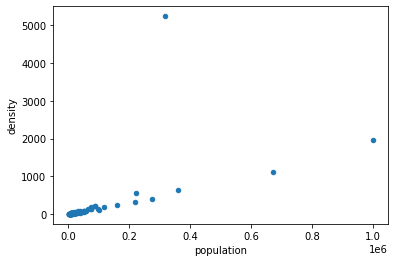

In [358]:
results.plot.scatter(x='population', y='density')

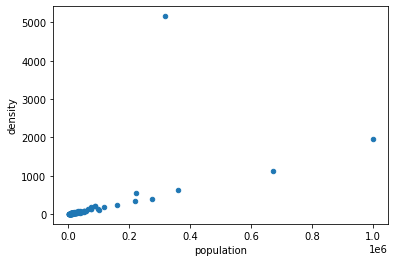

In [321]:
results.plot.scatter(x='population', y='density') 

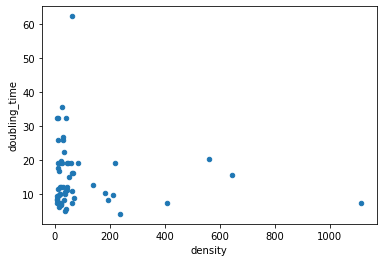

In [359]:
results.plot.scatter(x='density', y='doubling_time')

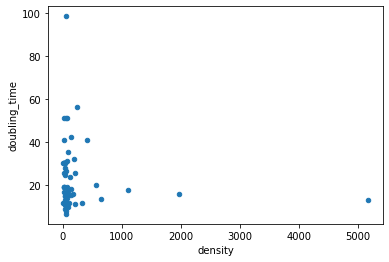

In [317]:
results.plot.scatter(x='density', y='doubling_time')

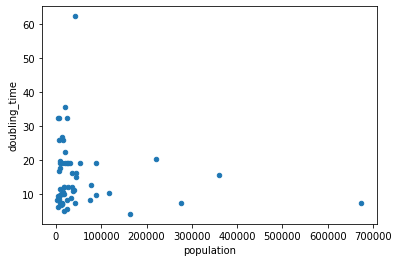

In [360]:
results.plot.scatter(x='population', y='doubling_time')

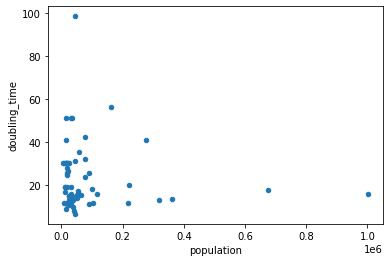

In [318]:
results.plot.scatter(x='population', y='doubling_time')

In [362]:
import seaborn as sns

[None]

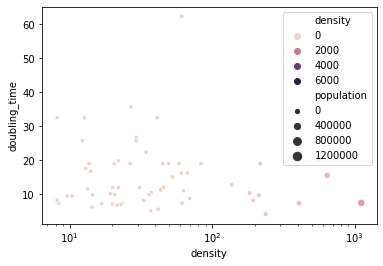

In [363]:
ax = sns.scatterplot(x="density", y="doubling_time",
                     hue="density", size="population",
                     data=results)

ax.set(xscale='log')

[None]

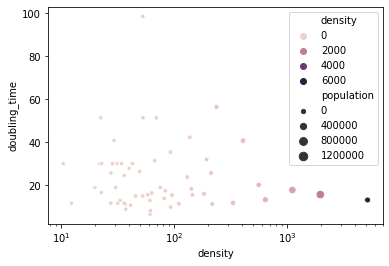

In [320]:
ax = sns.scatterplot(x="density", y="doubling_time",
                     hue="density", size="population",
                     data=results)

ax.set(xscale='log')